[Total marks: 2.5] Consider the dataset below (1.1). Find MLE estimate for parameters of a neural network for regression with Gaussian Homoskedastic noise, where noise variance has a fixed value = 0.0025. Your model summary should match with (1.2). Animate the MLE fit on the data along with the 95% noise variance intervals [2 marks]. What is the effect of varying the noise variance (only in model, not for regenerating the data) on the MLE fit, show it for 3 different noise variance values? [0.5 mark] Refer to this tutorial for building and training torch.nn models. Use FuncAnimation from matplotlib or Celluloid for animation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings('ignore')
from torchsummary import summary


In [2]:
# np.random.seed(0)
# X = np.linspace(0, 1, 100)
# noise = np.random.normal(0, 0.05, 100)
# y = np.sin(2 * np.pi * X) + noise

In [3]:
# plt.plot(X, y, 'o')

In [4]:
np.random.seed(0)
x_values = np.linspace(0, 1, 100)
noise = np.random.normal(0, np.sqrt(0.0025), 100)
y_values = np.sin(2 * np.pi * x_values) + noise
x_values = x_values.reshape(-1, 1)
y_values = y_values.reshape(-1, 1)

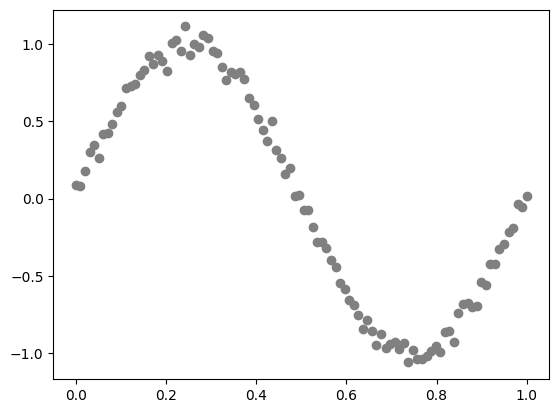

In [5]:
plt.scatter(x_values, y_values, label='Data with Noise', color='gray')


In [6]:
X_tensor = torch.tensor(x_values, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_values, dtype=torch.float32).unsqueeze(1)

In [7]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.linear1 = nn.Linear(1, 10)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(10, 10)
        self.selu = nn.SELU()
        self.linear3 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.linear2(x)
        x = self.selu(x)
        x = self.linear3(x)
        return x

model = RegressionModel()        


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

RegressionModel(
  (linear1): Linear(in_features=1, out_features=10, bias=True)
  (gelu): GELU(approximate='none')
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (selu): SELU()
  (linear3): Linear(in_features=10, out_features=1, bias=True)
)

In [11]:
summary(model,(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              20
              GELU-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              SELU-4                   [-1, 10]               0
            Linear-5                    [-1, 1]              11
Total params: 141
Trainable params: 141
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
